# PyTorch computer Vision

Useful Modules
- `torchvision`
- `torchvision.datasets`
- `torchvision.models`
- `torchvision.transforms`
- `torchvision.utils.data.Dataset`
- `torchvision.utils.data.DataLoader`

In [1]:
# Import torch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# import matplotlib and seaborn for visualization
import matplotlib.pyplot as plt
import seaborn

### Setting up Device Agnostic code

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
torch.cuda.is_available()

True

In [4]:
!nvidia-smi

Sat Jun 14 01:15:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.133.07             Driver Version: 570.133.07     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   54C    P8              3W /   60W |      18MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Loading the image data

In [4]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data= datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

test_data= datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [5]:
train_data.targets 

tensor([9, 0, 0,  ..., 3, 0, 5])

### Visualizing the data

In [6]:
class_names = train_data.classes

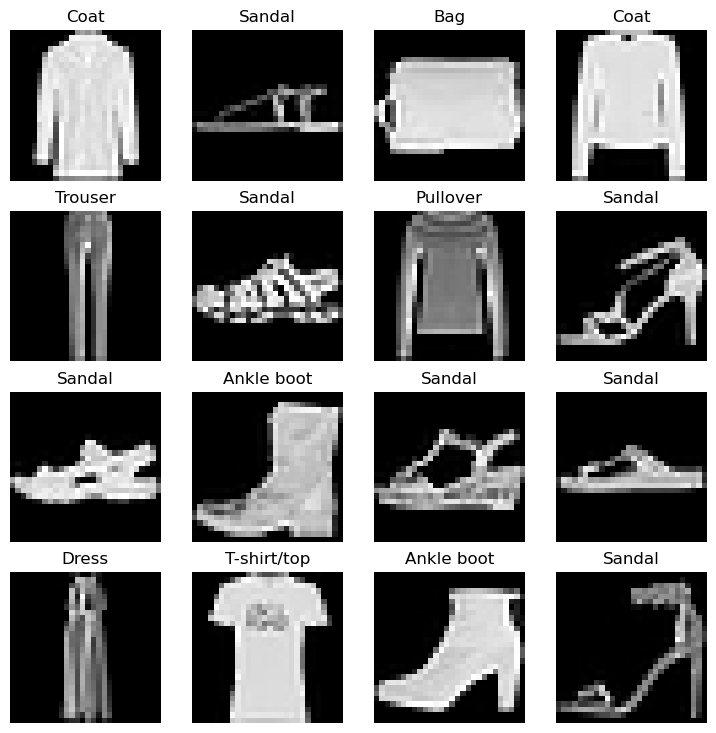

In [7]:
# torch.manual_seed(42)
fig= plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    rand_idx= torch.randint(0, len(train_data), size=[1]).item()
    img, label  = train_data[rand_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis(False)

### Creating a Dataloader- to turn data into python iterable for batches

In [8]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [9]:
print(len(train_dataloader), len(test_dataloader))

1875 313


Feature batch shape: torch.Size([32, 1, 28, 28])

Labels batch shape: torch.Size([32])



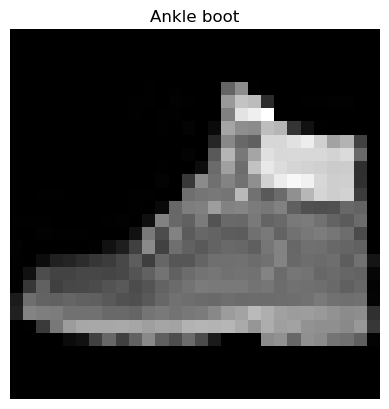

In [10]:
# Display image thorough Dataloader

train_features, train_labels= next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}\n")
print(f"Labels batch shape: {train_labels.size()}\n")

rand_idx = torch.randint(0, len(train_features), size=[1]).item()
img = train_features[rand_idx].squeeze()
label = train_labels[rand_idx]
plt.imshow(img, cmap="gray")
plt.axis(False)
plt.title(class_names[label])
plt.show()

### Model 0: Build a Baseline Model

In [11]:
# Build a flatten layer
flatten_model = nn.Flatten()

x= train_features[0]

output = flatten_model(x)

print(f'Before Flattening {x.shape}\nAfter Flattening {output.shape}')

Before Flattening torch.Size([1, 28, 28])
After Flattening torch.Size([1, 784])


In [12]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
    def __init__(self,
                input_shape:int,
                hidden_units:int,
                output_shape:int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [13]:
# torch.manual_seed(42)

model_0 = FashionMNISTModelV0(
    input_shape=28*28,
    hidden_units=10,
    output_shape=len(class_names)
).to(device)
model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [14]:
dummy_x = torch.rand([1,1,28,28]).to(device)
model_0(dummy_x)

tensor([[ 0.3348, -0.0865, -0.0228,  0.0015, -0.1699, -0.3404,  0.1706, -0.1839,
         -0.3152,  0.1076]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [15]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_function already exists")
else:
    print("Downloading the helper function")
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py')
    with open('helper_functions.py', "wb") as f:
        f.write(request.content)

helper_function already exists


In [16]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [17]:
### Creating a function to time our experiments
from timeit import default_timer as timer
def print_train_time(start:float,
                    end:float,
                    device: torch.device="cpu"):
    """Prints the difference between start time and end time"""
    total_time = end-start
    print(f'Train Time on {device}: {total_time:.3f} seconds')
    return total_time

### Creating a Training and Testing loop

In [18]:
from tqdm.auto import tqdm

torch.manual_seed(42)
s_time = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n-----')
    # Training
    train_loss = 0
    # Add a loop to loop training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        X, y = X.to(device), y.to(device)
        y_pred = model_0(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulate train loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if batch % 400 == 0:
            print(f"looked at {batch*len(X)}/{len(train_dataloader.dataset)} samples.")

    # Divide total train loss by length of train dataloader
    train_loss /= len(train_dataloader)

    ### Testing
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X_test,y_test in test_dataloader:
            X_test,y_test = X_test.to(device), y_test.to(device)
            test_pred = model_0(X_test)

            test_loss += loss_fn(test_pred, y_test)

            test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

        test_loss /= len(test_dataloader)
        
        test_acc /= len(test_dataloader)
        
        if batch % 400 == 0:
            print(f"\nTrain Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f} ")

e_time = timer()
total_time_model_0 = print_train_time(s_time, e_time, device='cpu')

/home/krrish/anaconda3/envs/torch_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|                                                     | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----
looked at 0/60000 samples.
looked at 12800/60000 samples.
looked at 25600/60000 samples.
looked at 38400/60000 samples.
looked at 51200/60000 samples.


 33%|███████████████                              | 1/3 [00:03<00:07,  3.76s/it]

Epoch: 1
-----
looked at 0/60000 samples.
looked at 12800/60000 samples.
looked at 25600/60000 samples.
looked at 38400/60000 samples.
looked at 51200/60000 samples.


 67%|██████████████████████████████               | 2/3 [00:07<00:03,  3.69s/it]

Epoch: 2
-----
looked at 0/60000 samples.
looked at 12800/60000 samples.
looked at 25600/60000 samples.
looked at 38400/60000 samples.
looked at 51200/60000 samples.


100%|█████████████████████████████████████████████| 3/3 [00:10<00:00,  3.63s/it]

Train Time on cpu: 10.894 seconds


In [19]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [20]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0055,  0.0358, -0.0307,  ...,  0.0569,  0.0167,  0.0063],
                      [-0.0186, -0.0089, -0.0132,  ...,  0.0063,  0.0155, -0.0206],
                      [-0.0053, -0.0161, -0.0169,  ..., -0.0406, -0.0104, -0.0115],
                      ...,
                      [-0.0046,  0.0160, -0.0156,  ...,  0.0419,  0.0315,  0.0105],
                      [ 0.0084, -0.0202, -0.0064,  ..., -0.1260, -0.0216, -0.0208],
                      [ 0.0057, -0.0177,  0.0140,  ..., -0.0151, -0.0195,  0.0290]],
                     device='cuda:0')),
             ('layer_stack.1.bias',
              tensor([ 0.5738,  0.5875, -0.4455,  0.7913, -0.7427,  0.3157, -0.7538, -0.6882,
                       0.8158,  0.1496], device='cuda:0')),
             ('layer_stack.2.weight',
              tensor([[-7.1500e-02,  1.5859e-01,  3.0701e-01,  3.4817e-01,  1.6780e-01,
                       -1.9831e-01, -3.7424e-01, -2.0077e-01,  2.5826e-01,

In [21]:
# torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device=device
              ):
    """Return a Dictionary containing the results of model prediciting on data loader"""
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X,y in data_loader:
            X,y = X.to(device), y.to(device)
            # Make predictions
            y_pred = model(X.to(device))

            # Accumulate loss and accuracy
            loss +=  loss_fn(y_pred.to(device), y.to(device))
            acc  +=  accuracy_fn(y.to(device), y_pred.argmax(dim=1).to(device))

        # Scale loss and acc to find average loss/acc per batch
        loss /= len(data_loader)
        acc  /= len(data_loader)

    return {"model_name": model.__class__.__name__, 
            "model_loss": loss.item(),
            "model_acc":  acc}

model_0_results = eval_model(model_0, test_dataloader, loss_fn, accuracy_fn)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47816401720046997,
 'model_acc': 83.39656549520767}

### Improving through Experimentation
- #### Building model with non-linearity
- #### GridSearchCV to find better values for hyperparameter 


In [61]:
# Create a model with non-linear and linear layers
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)



In [62]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784, # number of input features
    hidden_units=10,
    output_shape=len(class_names) # number of output classes desired
).to(device) # send model to GPU if it's available
next(model_1.parameters()).device # check model device

device(type='cuda', index=0)

In [35]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [36]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(params=model_1.parameters(), lr=0.1)

### Creating a Function for Training and Testing loop

In [63]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")



In [64]:
accuracy_fn

<function helper_functions.accuracy_fn(y_true, y_pred)>

In [65]:
# Measure time
from helper_functions import accuracy_fn
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 5
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_1, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)



  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 2.30166 | Train accuracy: 11.31%


 20%|█████████                                    | 1/5 [00:03<00:15,  3.87s/it]

Test loss: 2.30211 | Test accuracy: 10.75%

Epoch: 1
---------
Train loss: 2.30166 | Train accuracy: 11.31%


 40%|██████████████████                           | 2/5 [00:07<00:11,  3.84s/it]

Test loss: 2.30211 | Test accuracy: 10.75%

Epoch: 2
---------
Train loss: 2.30166 | Train accuracy: 11.31%


 60%|███████████████████████████                  | 3/5 [00:11<00:07,  3.72s/it]

Test loss: 2.30211 | Test accuracy: 10.75%

Epoch: 3
---------
Train loss: 2.30166 | Train accuracy: 11.31%


 80%|████████████████████████████████████         | 4/5 [00:15<00:03,  3.77s/it]

Test loss: 2.30211 | Test accuracy: 10.75%

Epoch: 4
---------
Train loss: 2.30166 | Train accuracy: 11.31%


100%|█████████████████████████████████████████████| 5/5 [00:18<00:00,  3.74s/it]

Test loss: 2.30211 | Test accuracy: 10.75%

Train Time on cuda: 18.712 seconds


In [66]:
model_1_results = eval_model(model_1, test_dataloader,loss_fn, accuracy_fn)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 2.3021068572998047,
 'model_acc': 10.75279552715655}

## Building a CNN model

### Also known ad ConvNets
### CNN are known for their Capabilities to find pattern in visual data
https://poloclub.github.io/cnn-explainer/

In [99]:
# create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
    """
    Model Architecture that replicates the TinyVGG
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape:int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block_2 =nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # also called output_layer or classifier layer
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # there's a trick to calculate this in_features, 
            # print output shape of both conv block and put H W of last block in output layer
            nn.Linear(in_features=hidden_units*7*7, 
                     out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        print(f'Output shape of conv block 1: {x.shape}')
        x = self.conv_block_2(x)
        print(f'Output shape of conv block 2: {x.shape}')
        x = self.classifier(x)
        print(f'Output shape of classifier: {x.shape}')
        return x

In [102]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(
    input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)
                    ).to(device)

In [103]:
rand_image = torch.randn(size=(1,28,28)).to(device)
model_2(rand_image.unsqueeze(0))
# rand_image.unsqueeze(0).shape

Output shape of conv block 1: torch.Size([1, 10, 14, 14])
Output shape of conv block 2: torch.Size([1, 10, 7, 7])
Output shape of classifier: torch.Size([1, 10])


tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [104]:
model_2.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[ 0.2548,  0.2767, -0.0781],
                        [ 0.3062, -0.0730,  0.0673],
                        [-0.1623,  0.1958,  0.2938]]],
              
              
                      [[[-0.2445,  0.2897,  0.0624],
                        [ 0.2463,  0.0451,  0.1607],
                        [-0.0471,  0.2570,  0.0493]]],
              
              
                      [[[-0.1556,  0.0850, -0.1536],
                        [-0.0391, -0.1354,  0.2211],
                        [-0.2631, -0.1537, -0.0941]]],
              
              
                      [[[-0.2004,  0.0315, -0.3292],
                        [ 0.3010, -0.2832,  0.2573],
                        [ 0.0555, -0.1082,  0.2060]]],
              
              
                      [[[ 0.0520,  0.2693,  0.0364],
                        [-0.1051,  0.0896, -0.0904],
                        [ 0.1403,  0.2976,  0.1927]]],
              
              
      

In [55]:
torch.manual_seed(42)

# create a batch of images
images = torch.randn(size=(32,3,64,64))
test_image = images[0]

print(f'Image Batch size: {images.shape}')
print(f'Single Image size: {test_image.shape}')
print(f'Test Image: {test_image}')

Image Batch size: torch.Size([32, 3, 64, 64])
Single Image size: torch.Size([3, 64, 64])
Test Image: tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0.79

In [68]:
# create a single Conv2d layer
torch.manual_seed(42)
conv_layer = nn.Conv2d(
    in_channels=3,
    out_channels=10,
    kernel_size=(3,3),
    stride=1,
    padding=1
)

conv_output = conv_layer(test_image)
conv_output.shape

torch.Size([10, 64, 64])

In [69]:
torch.__version__

'2.5.1'

### Stepping through `nn.MaxPool2d()`

In [70]:
print(f'Test Original shape: {test_image.shape}')
print(f'Test image unsqueezed shape: {test_image.unsqueeze(0).shape}')

max_pool_layer = nn.MaxPool2d(kernel_size=2)

test_image_through_conv = conv_layer(test_image)
print(f'Test image after going through Conv2d layer: {test_image_through_conv.shape}')

test_image_through_conv_max_pool = max_pool_layer(test_image_through_conv)
print(f'Test image after going through Conv2d layer and max pool layer: {test_image_through_conv_max_pool.shape}')


Test Original shape: torch.Size([3, 64, 64])
Test image unsqueezed shape: torch.Size([1, 3, 64, 64])
Test image after going through Conv2d layer: torch.Size([10, 64, 64])
Test image after going through Conv2d layer and max pool layer: torch.Size([10, 32, 32])
